### 📦 1 | Install & Import Required Packages
---

**1.1 | Install Required Packages**

In [ ]:
!pip install biopython >/dev/null
!pip install plotnine >/dev/null

**1.2 | Import Required Packages**

In [ ]:
from    Bio import Entrez
import  pandas as pd
from    datetime import datetime
import  matplotlib.pyplot as plt
from    plotnine import *
from    mizani.formatters import comma_format
import  time

### 🔧 2 | Parameters
---

In [ ]:
# Create list of diseases for plotting | ['Long Covid', 'ME/CFS', 'Fibromyalgia', 'POTS', 'MCAS', 'Chronic Lyme', 'Dysautonomia', 'HIV/AIDS', 'Multiple Sclerosis']
disease_list = ['Long Covid', 'ME/CFS', 'Fibromyalgia', 'POTS', 'MCAS', 'Chronic Lyme', 'Dysautonomia', 'HIV/AIDS', 'Multiple Sclerosis']

# Define the start and end years for the PubMed API search
start_year = 1980
end_year = 2023

# Define single year for across-disease comparison
single_year = 2023

# Define disease colours
disease_colors = {
    "ME/CFS": "#7BB3F3",
    "Long Covid": "#E57399",
    "Fibromyalgia": "#FFD8A8",
    "POTS": "#B6FDFF",
    "MCAS": "#FFC2E6",
    "Chronic Lyme": "#E0FFAA",
    "Dysautonomia": "#D7B3FF",
    "HIV/AIDS": "#F2A9A1",
    "Multiple Sclerosis": "#D3D3D3"
}

# Dictionary of search terms for PubMed API search
search_terms = {
    "ME/CFS": (
        '("ME/CFS" '
        'OR "Myalgic Encephalomyelitis" '
        'OR "Chronic Fatigue Syndrome" '
        'OR "Systemic Exertion Intolerance Disease")'
    ),
    "Long Covid": (
        '("Long Covid" '
        'OR "Post-COVID Syndrome" '
        'OR "Long-Haul COVID" '
        'OR "Post-acute sequelae of COVID-19" '
        'OR "PASC" '
        'OR "Post-COVID-19 condition")'
    ),
    "Fibromyalgia": (
        '("Fibromyalgia" '
        'OR "Fibromyalgia Syndrome")'
    ),
    "POTS": (
        '("Postural Tachycardia Syndrome" '
        'OR "PoTS" '
        'OR "POTS" '
        'OR "Postural Orthostatic Tachycardia Syndrome")'
    ),
    "MCAS": (
        '("Mast Cell Activation Syndrome" '
        'OR "MCAS" '
        'OR "mast cell activation disorder" '
        'OR "MCAD")'
    ),
    "Dysautonomia": (
        '("Dysautonomia")'
    ),
    "Chronic Lyme": (
        '("Chronic Lyme" '
        'OR "Chronic Lyme Disease" '
        'OR "Chronic Lyme Borreliosis" '
        'OR "Chronic Borreliosis" '
        'OR "Persistent Lyme Infection" '
        'OR "Persistent Borrelia Infection" '
        'OR "Post-Lyme Disease Syndrome" '
        'OR "PLDS" '
        'OR "Post-Treatment Lyme Disease Syndrome" '
        'OR "PTLDS" '
        'OR "Late-Stage Lyme Disease" '
        'OR "Late Disseminated Lyme Disease" '
        'OR "Neuroborreliosis")'
    ),
    "Multiple Sclerosis": (
        '("Multiple Sclerosis")'
    ),
    "HIV/AIDS": (
        '("HIV" '
        'OR "AIDS" '
        'OR "HIV/AIDS" '
        'OR "Human Immunodeficiency Virus")'
    )
}

### 🚰  3 | Data Import - from PubMed API
---

In [ ]:
def fetch_pubmed_data_for_multiple_terms(search_terms, start_year, end_year):
    """
    Fetches publication counts from PubMed for multiple search terms over a range of years.

    :param search_terms: Dictionary of search terms (diseases) and their PubMed query strings.
                        IMPORTANT: Multi-word phrases should be surrounded by quotes
                        if you want them treated as an exact phrase.
    :param start_year: Start year for the data collection.
    :param end_year: End year for the data collection.
    :return: DataFrame with years as rows and diseases as columns, containing publication counts.
    """
    # Always set your email before using Entrez
    Entrez.email = "rory@eudemo.co"

    publication_counts = {term: [] for term in search_terms}
    years = range(start_year, end_year + 1)

    for year in years:
        for disease_label, query in search_terms.items():
            # Construct the query with [dp] (date of publication)
            full_query = f"{query} AND ({year}[dp])"

            handle = Entrez.esearch(db="pubmed", term=full_query, retmax=100000)
            record = Entrez.read(handle)
            count = int(record["Count"])
            publication_counts[disease_label].append(count)
            handle.close()

            # Optional: small sleep to respect NCBI rate limits (~3 requests/sec)
            #time.sleep(0.34)

    # Create a DataFrame from the collected data
    df = pd.DataFrame(publication_counts, index=years)
    df.index.name = 'Year'
    return df

# Fetching the data (to be executed in an environment where Biopython is installed)
publications_df = fetch_pubmed_data_for_multiple_terms(search_terms, start_year, end_year)

# Check result
publications_df.tail()

,ME/CFS,Long Covid,Fibromyalgia,POTS,MCAS,Dysautonomia,Chronic Lyme,Multiple Sclerosis,HIV/AIDS
Year,,,,,,,,,
2019,340,21,704,300,116,158,211,5669,20888
2020,329,81,827,455,119,226,211,6425,22911
2021,438,882,893,546,171,302,226,6853,23662
2022,386,2242,891,530,148,256,219,6687,23218
2023,424,2755,960,550,170,280,196,5991,21731


In [ ]:
# Transforming the DataFrame to long format
df_long = publications_df.reset_index().melt(id_vars='Year', var_name='Disease', value_name='Publications')

# Calculating cumulative publications for each disease
df_long['Cumulative Publications'] = df_long.groupby('Disease')['Publications'].cumsum()

# Check result
df_long

,Year,Disease,Publications,Cumulative Publications
0,1980,ME/CFS,5,5
1,1981,ME/CFS,5,10
2,1982,ME/CFS,1,11
3,1983,ME/CFS,2,13
4,1984,ME/CFS,6,19
...,...,...,...,...
391,2019,HIV/AIDS,20888,481548
392,2020,HIV/AIDS,22911,504459
393,2021,HIV/AIDS,23662,528121
394,2022,HIV/AIDS,23218,551339


### 🥋 4 | Data Wrangling
---

In [ ]:
# Filter dataframe for required diseases
df_plot_disease = df_long[df_long['Disease'].isin(disease_list)]

# Check result
df_plot_disease.head(5)

,Year,Disease,Publications,Cumulative Publications
0,1980,ME/CFS,5,5
1,1981,ME/CFS,5,10
2,1982,ME/CFS,1,11
3,1983,ME/CFS,2,13
4,1984,ME/CFS,6,19


In [ ]:
# Filter for specific year selected
df_plot_disease_year = df_plot_disease[df_plot_disease['Year']==single_year]

# Sort values on Publications
df_plot_disease_year = df_plot_disease_year.sort_values('Publications', ascending=False)

# Changing 'Disease' to a categorical type with ordered categories
df_plot_disease_year['Disease'] = pd.Categorical(df_plot_disease_year['Disease'], categories=df_plot_disease_year['Disease'].unique())

# Check result
df_plot_disease_year

,Year,Disease,Publications,Cumulative Publications
395,2023,HIV/AIDS,21731,573070
351,2023,Multiple Sclerosis,5991,108536
87,2023,Long Covid,2755,6185
131,2023,Fibromyalgia,960,15524
175,2023,POTS,550,6460
43,2023,ME/CFS,424,8994
263,2023,Dysautonomia,280,3493
307,2023,Chronic Lyme,196,4411
219,2023,MCAS,170,2485


### 📈  5 | Visualise Results
---

#### 5.1 | Publications Per Year By Disease

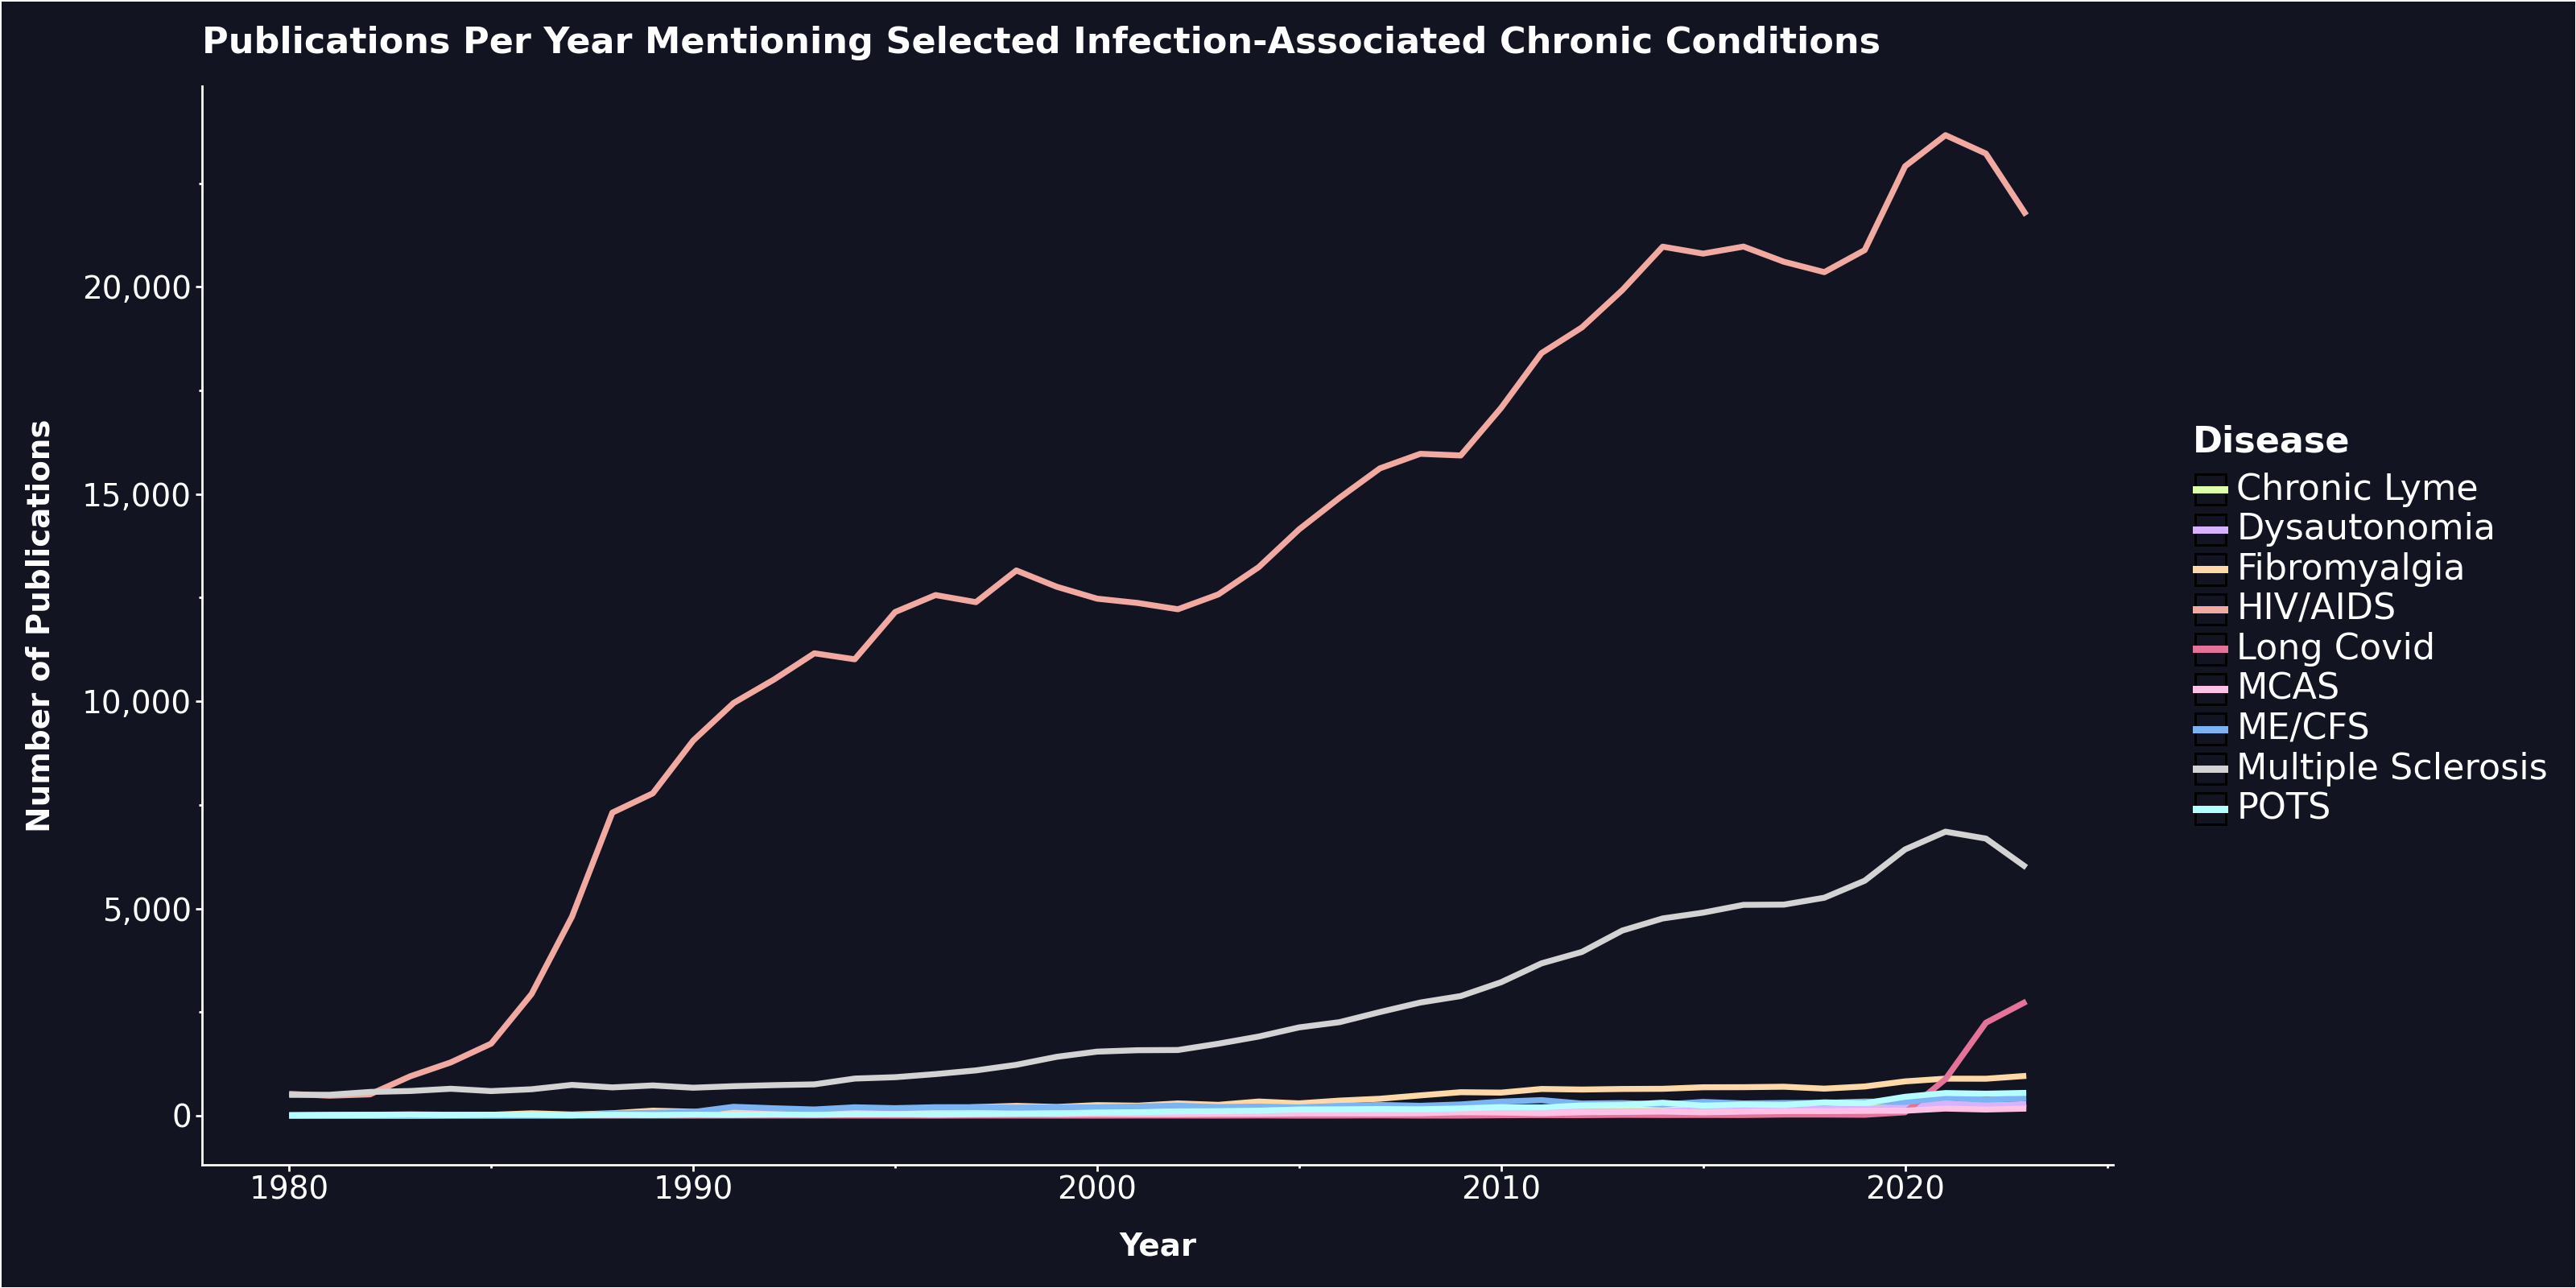

In [ ]:
# Update the plot with pastel colors
plot = (ggplot(df_plot_disease, aes(x='Year', y='Publications', color='Disease')) +
        geom_line(size=1.5) +
        labs(title='Publications Per Year Mentioning Selected Infection-Associated Chronic Conditions',
             x='Year',
             y='Number of Publications') +
        theme_classic() +
        theme(
            figure_size=(16, 8),
            axis_title=element_text(size=14, weight='bold', color='white'),
            axis_text=element_text(size=14, color='white'),
            plot_title=element_text(size=16, weight='bold', color='white', hjust=0),
            legend_title=element_text(size=16, weight='bold', color='white'),
            legend_text=element_text(size=16, color='white'),
            plot_background=element_rect(fill='#121421', color=None),
            panel_background=element_rect(fill='#121421', color=None),
            legend_background=element_rect(fill='#121421', color=None),
            legend_key=element_rect(fill='#121421', color=None),
            axis_line=element_line(color='white', size=1),
            axis_ticks=element_line(color='white', size=1)
        ) +
        scale_y_continuous(labels=comma_format()) +
        scale_x_continuous(limits=[1980, 2023]) +
        scale_color_manual(values=disease_colors)
       )

# Display the plot
plot

#### 5.2 | Cumulative Publications Over Time By Disease

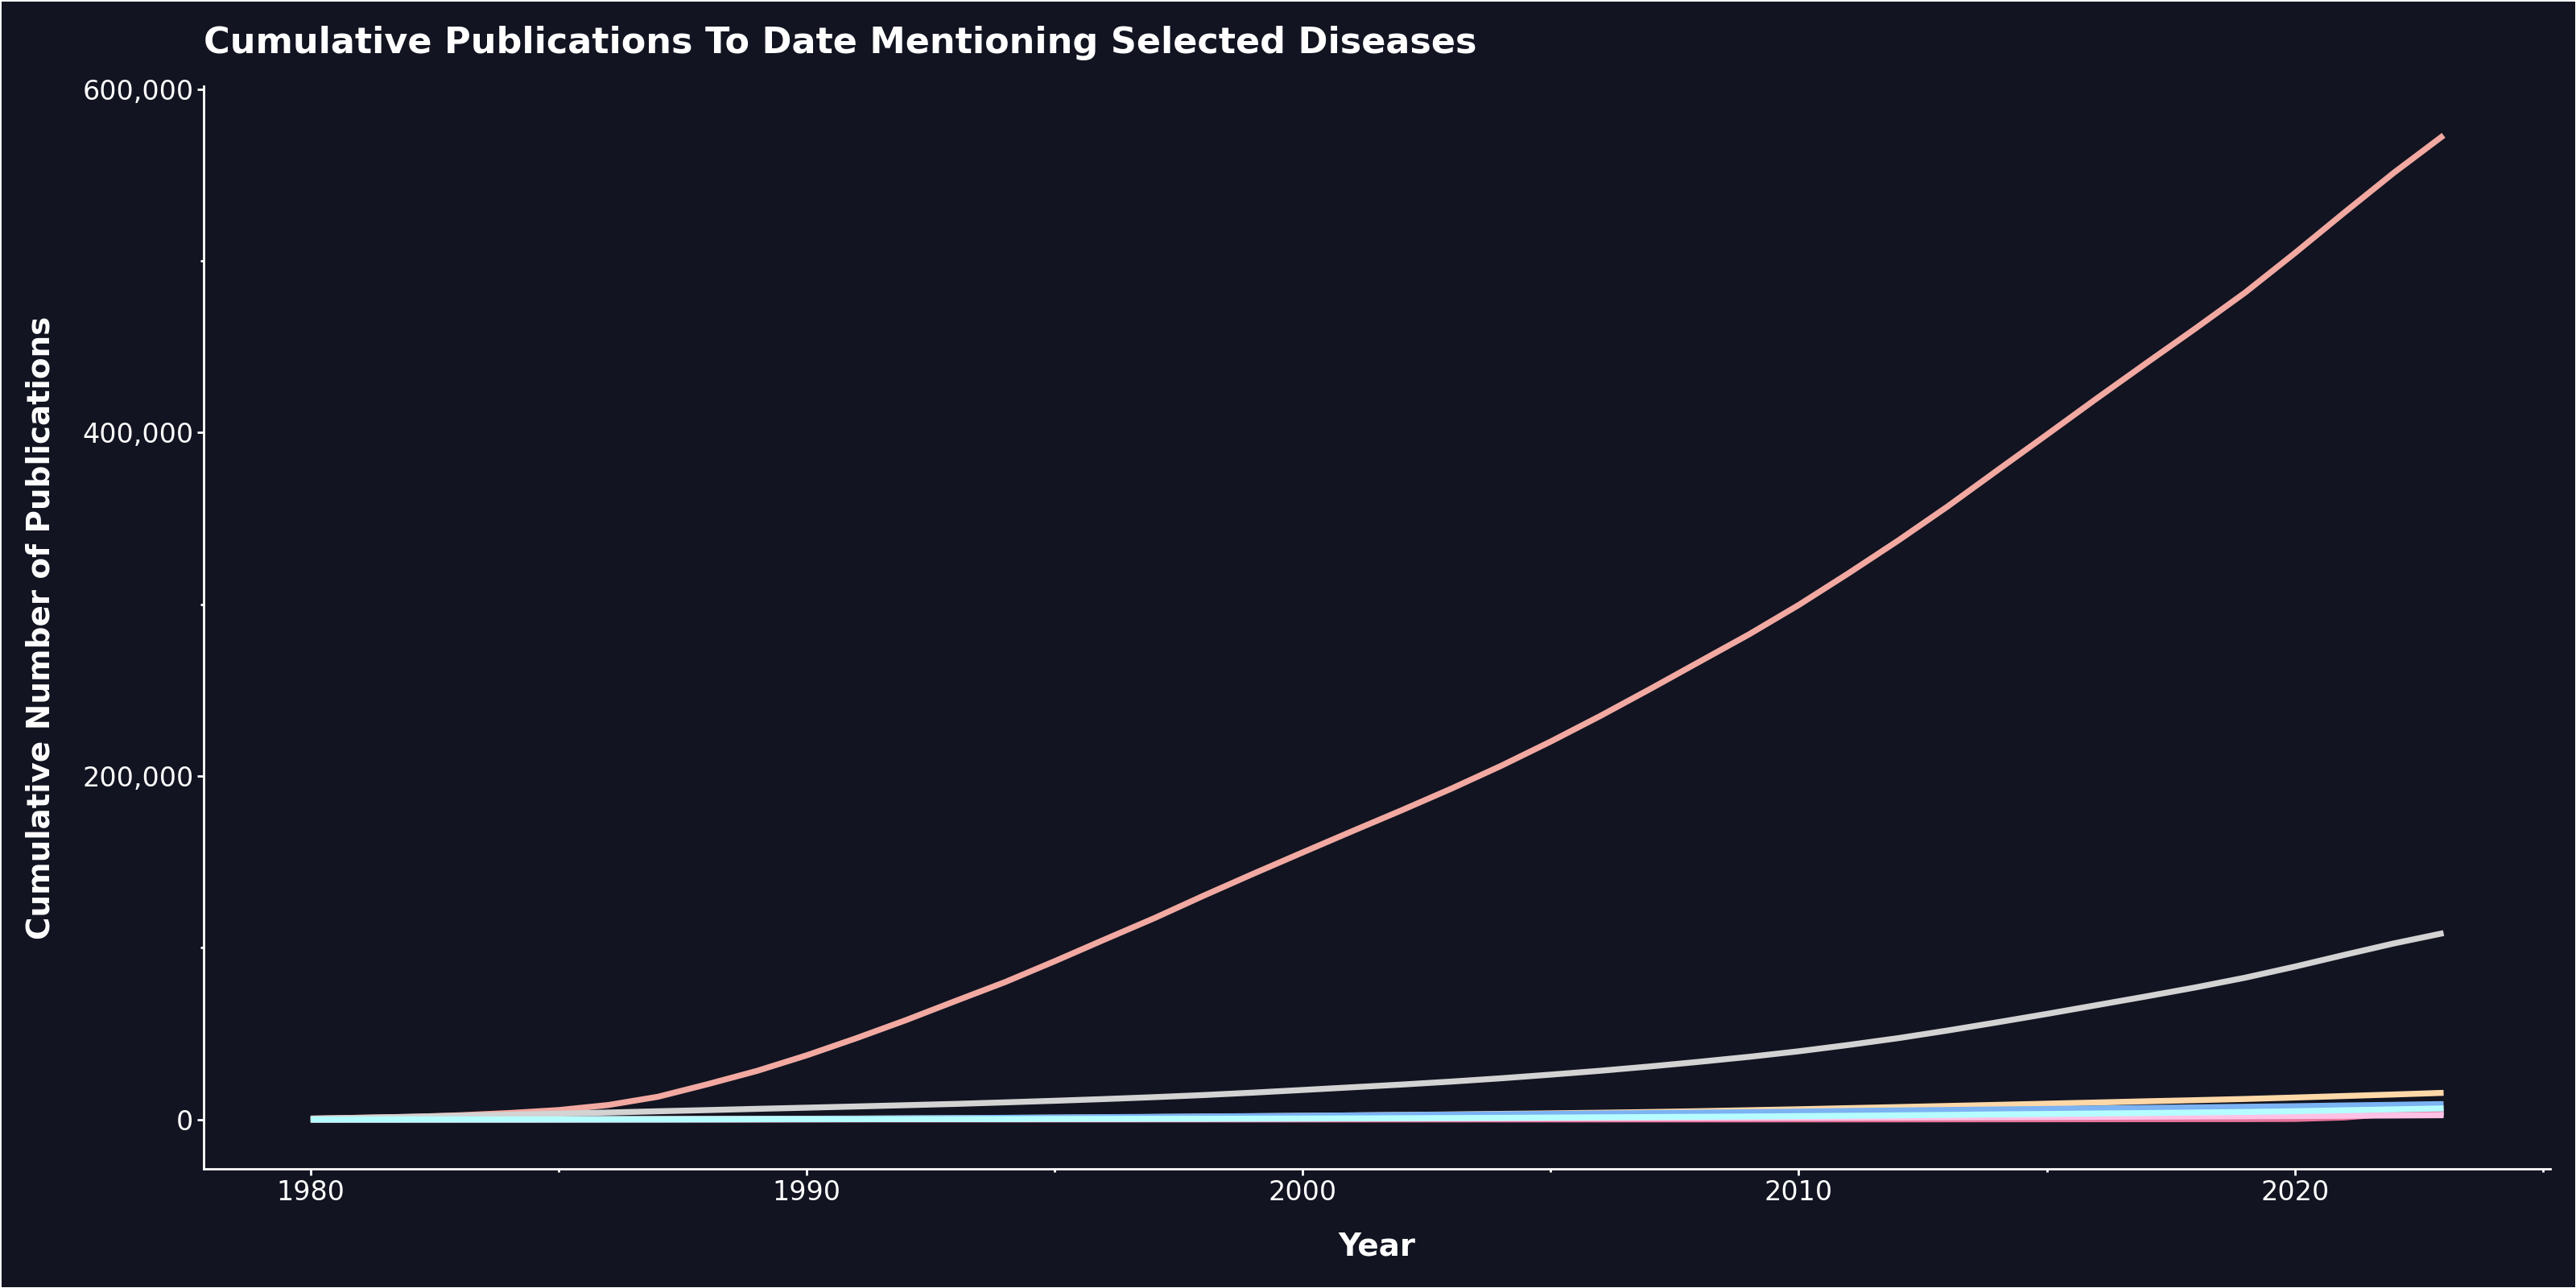

In [ ]:
# Update the cumulative plot with the new styling
cumulative_plot = (ggplot(df_plot_disease, aes(x='Year', y='Cumulative Publications', color='Disease')) +
                   geom_line(size=1.5) +
                   labs(title='Cumulative Publications To Date Mentioning Selected Diseases',
                        x='Year',
                        y='Cumulative Number of Publications') +
                   theme_classic() +
                   theme(
                       figure_size=(16, 8),
                       axis_title=element_text(size=14, weight='bold', color='white'),
                       axis_text=element_text(size=12, color='white'),
                       plot_title=element_text(size=16, weight='bold', color='white', hjust=0),
                       legend_title=element_text(size=16, weight='bold', color='white'),
                       legend_text=element_text(size=16, color='white'),
                       plot_background=element_rect(fill='#121421', color=None),
                       panel_background=element_rect(fill='#121421', color=None),
                       legend_background=element_rect(fill='#121421', color=None),
                       legend_key=element_rect(fill='#121421', color=None),
                       axis_line=element_line(color='white', size=1),
                       axis_ticks=element_line(color='white', size=1),
                       legend_position='none'
                   ) +
                   scale_y_continuous(labels=comma_format()) +
                   scale_color_manual(values=disease_colors)
                  )

# Display the plot
cumulative_plot

#### 5.3 | Publications By Disease for Given Year

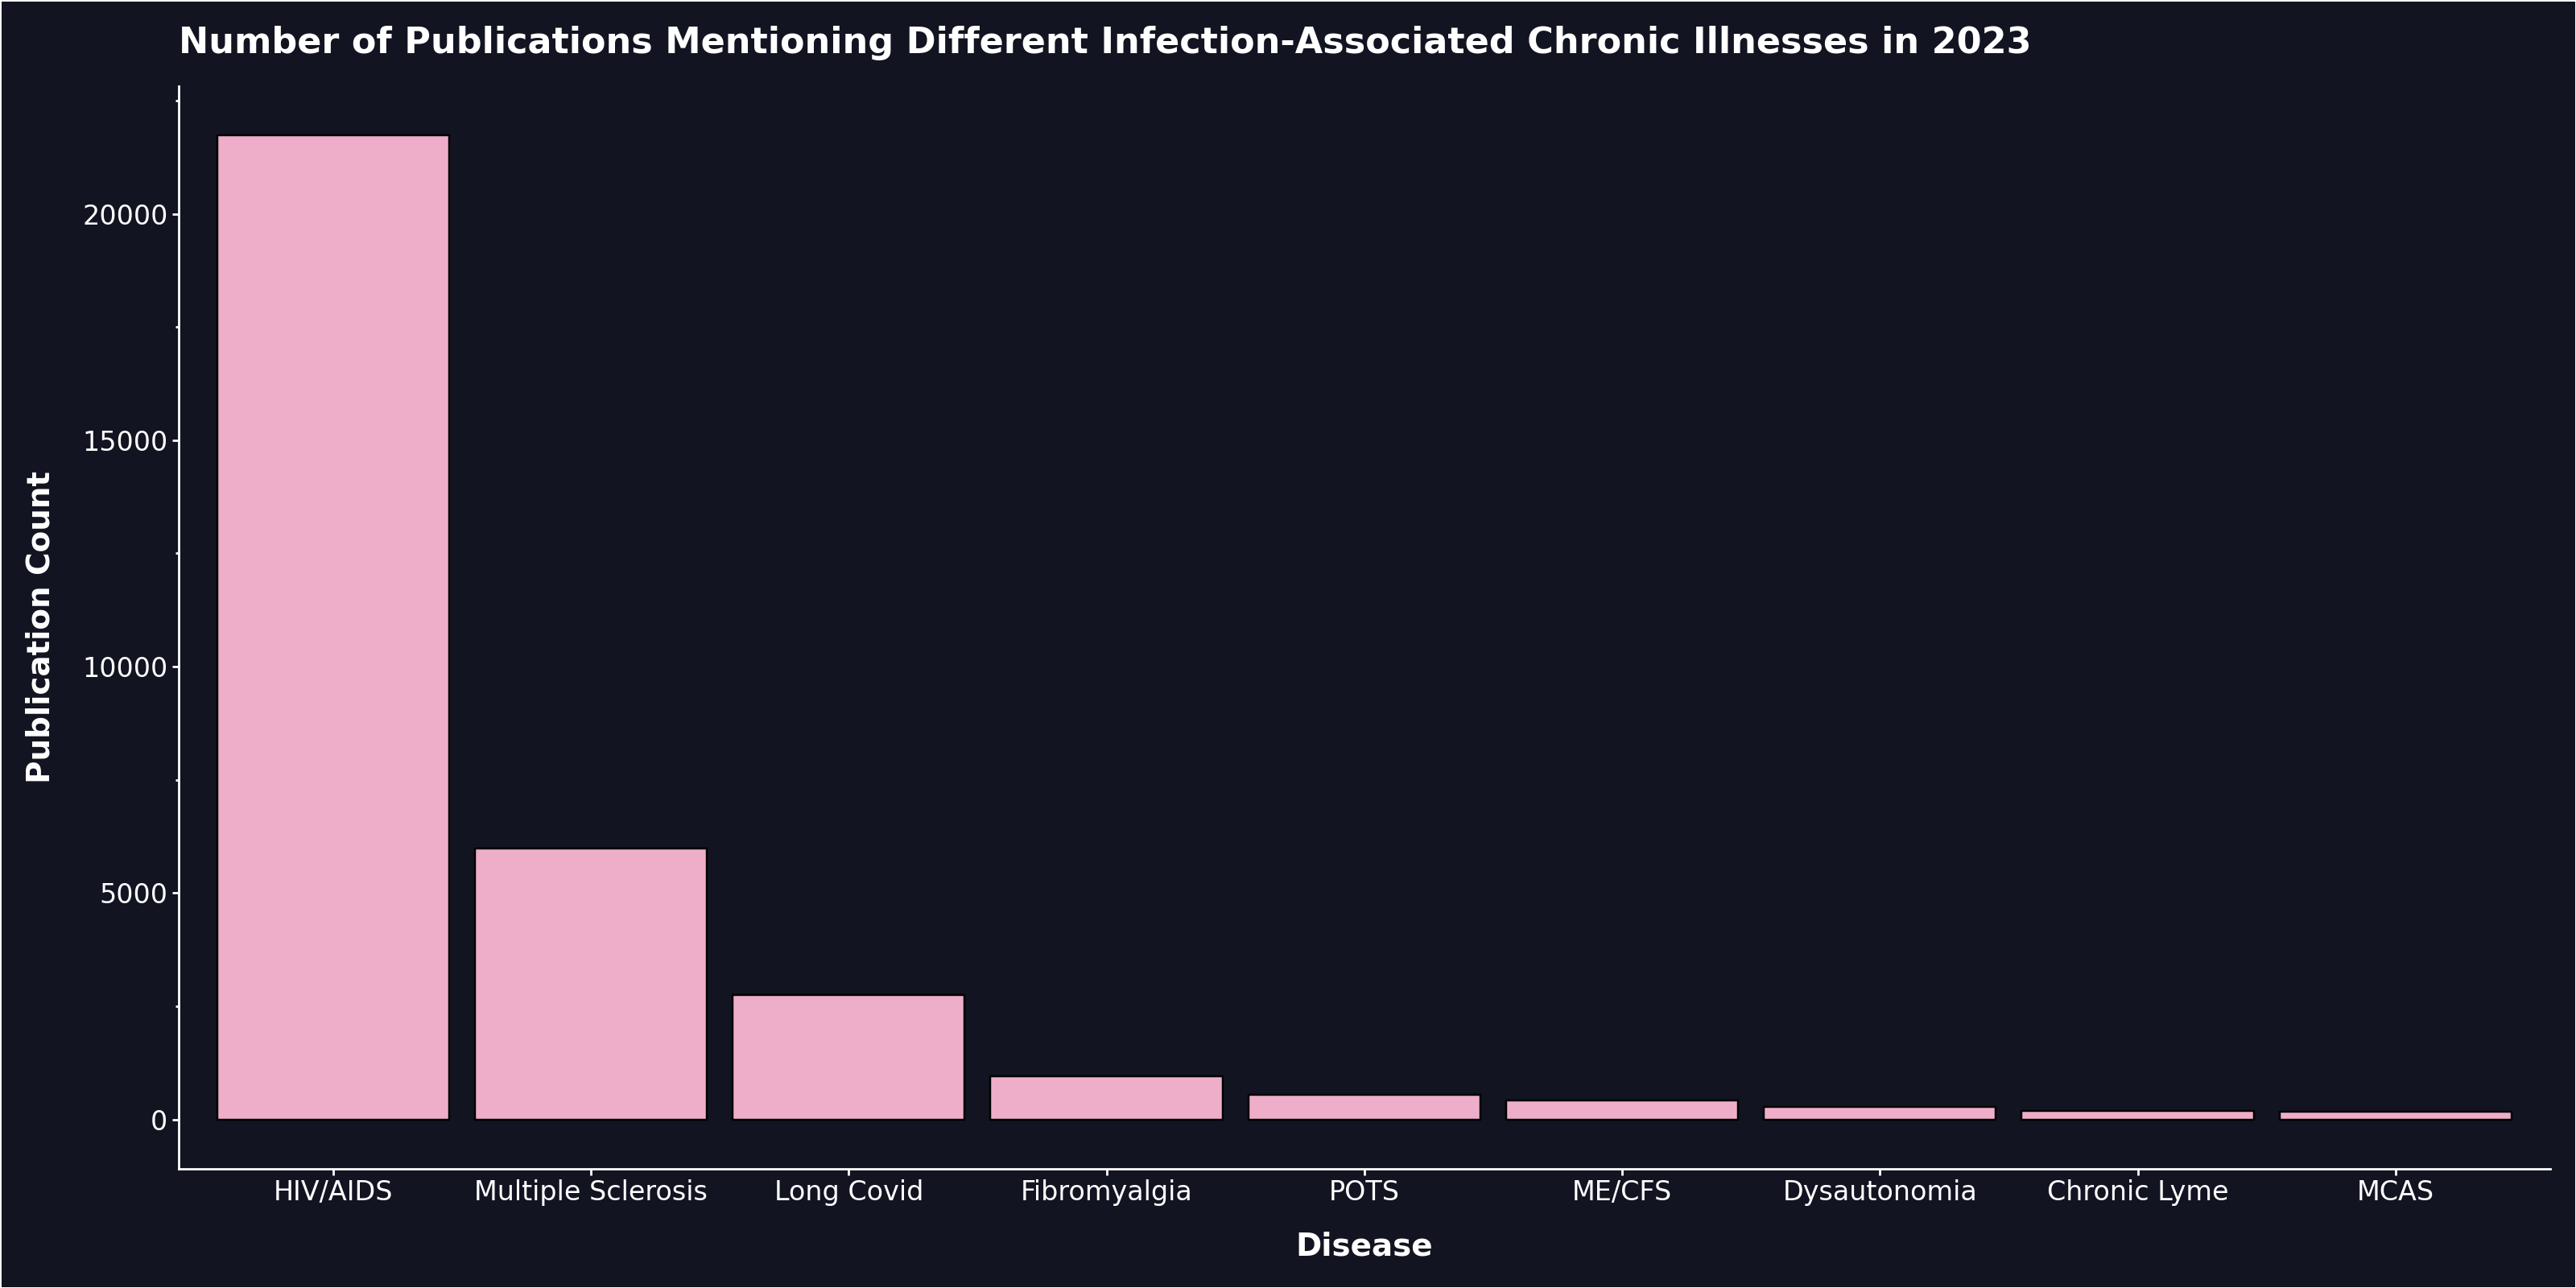

In [ ]:
# Create a bar plot
bar_plot = (
    ggplot(df_plot_disease_year, aes(x='Disease', y='Publications'))
    + geom_bar(stat='identity', fill='#EEAEC9', color='black')
    + labs(x='Disease', y='Publication Count', title='Number of Publications Mentioning Different Infection-Associated Chronic Illnesses in 2023')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + theme_classic()
    + theme(
            figure_size=(16, 8),
            axis_title=element_text(size=14, weight='bold', color='white'),
            axis_text=element_text(size=12, color='white'),
            plot_title=element_text(size=16, weight='bold', color='white', hjust=0),
            legend_text=element_text(size=16, color='white'),
            plot_background=element_rect(fill='#121421', color=None),
            panel_background=element_rect(fill='#121421', color=None),
            legend_background=element_rect(fill='#121421', color=None),
            legend_key=element_rect(fill='#121421', color=None),
            axis_line=element_line(color='white', size=1),
            axis_ticks=element_line(color='white', size=1)
          )
)

# Display the plot
bar_plot